In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import RandomForestRegressor
% matplotlib inline

In [2]:
#read Input Data file
df = pd.read_excel('One Line Input Data-model.xlsx').drop('MD-TVD',axis = 1)
d = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,\
     'OCT':10,'NOV':11,'DEC':12}
df.Month=df.Month.map(d)
df['Mon_int'] = (df.Year-2000)*12+df.Month

In [3]:
#numerical and catagorical feature
numcols = ['Surface Latitude','Surface Longitude','Total Proppant (lbs)',\
          'Total Fluid (gals)','Depth Total Driller',\
          'Lat Len Gross Perf Intvl','Depth True Vertical',\
          'Mon_int']
catcols = [x for x in df.columns if x not in numcols]

In [4]:
#missing value visualization (numerical features only)
missing_df = (df[numcols]==0).sum(axis=0).to_frame().reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

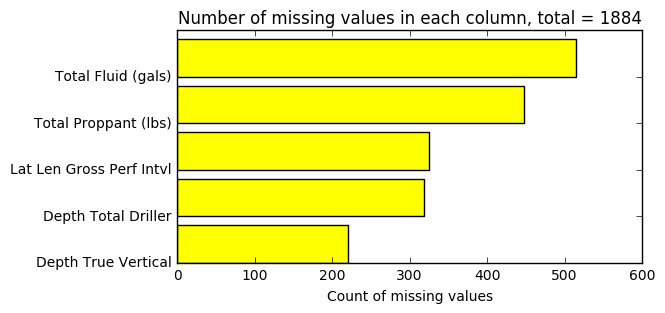

In [5]:
#missing_df = missing_df[missing_df.column_name!='Surface Longitude']
ind = np.arange(missing_df.shape[0]) 
fig,ax = plt.subplots(figsize=(6,3))
rects = ax.barh(ind, missing_df.missing_count.values, color='yellow')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column, total = %s" \
             %(df.shape[0]))

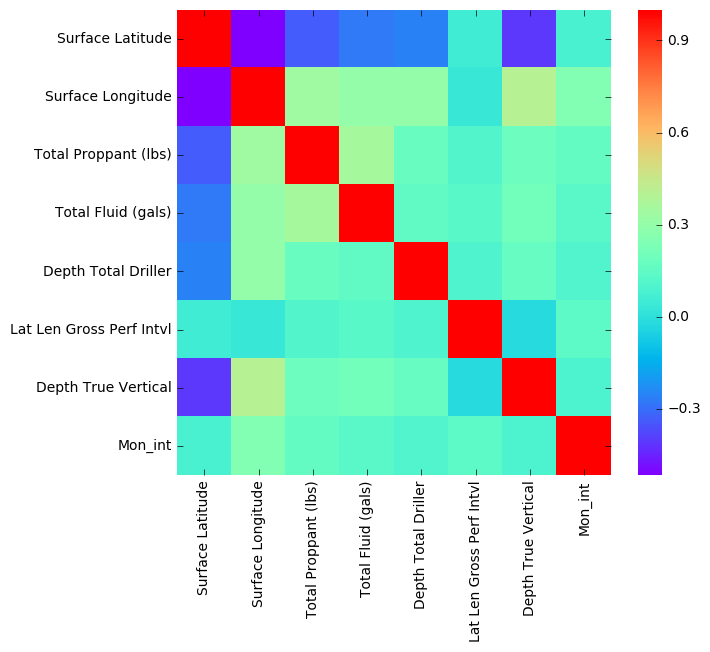

In [6]:
plt.figure(figsize = (7,6))
sns.heatmap(data=df[numcols].corr(),cmap="rainbow")
plt.show()

In [7]:
#label encoding for operator name
le_op = preprocessing.LabelEncoder()
df['optor_le'] = le_op.fit_transform(df['Operator Name'])
##list(le_op.inverse_transform(df['optor_le']))

In [8]:
#Formation Producing
F_filter = df['Formation Producing Name']==0
data_full =df[~F_filter]
data_x = data_full[['Surface Latitude','Surface Longitude','optor_le',\
'Mon_int']]
data_y = data_full['Formation Producing Name']
le_f = preprocessing.LabelEncoder()
data_y_le=le_f.fit_transform(data_y)
list(le_f.inverse_transform(data_y_le))

pred = df[F_filter]
pred_x = pred[['Surface Latitude','Surface Longitude','optor_le',\
'Mon_int']]

X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y_le, test_size=0.33, random_state=0)

In [9]:
X_test.to_csv('test_set.csv')
test_data = pd.read_csv("test_set.csv")

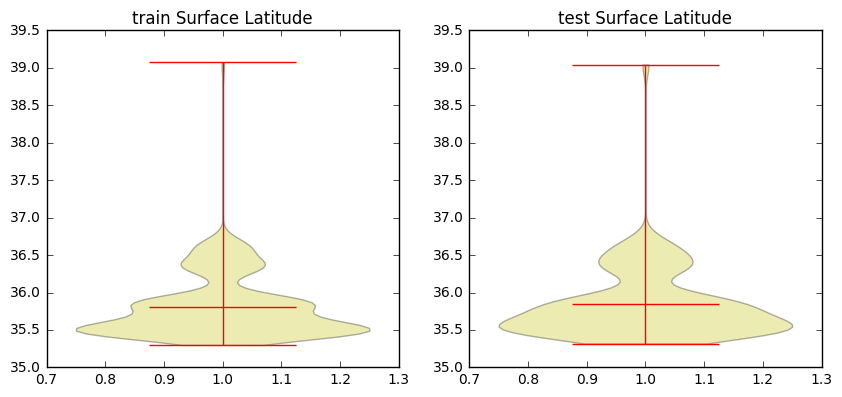

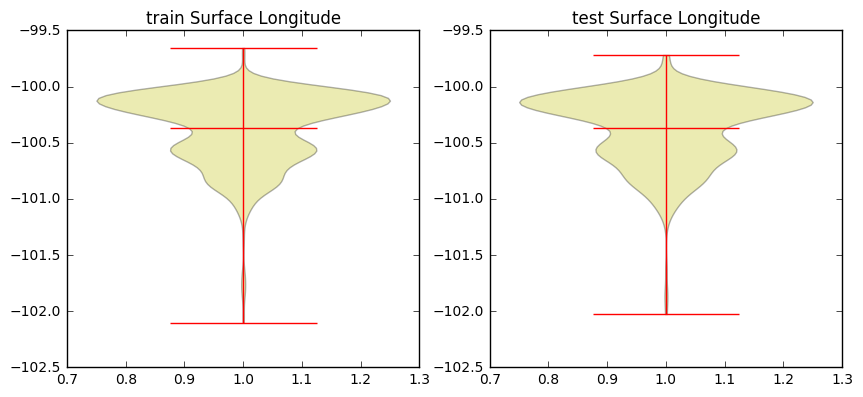

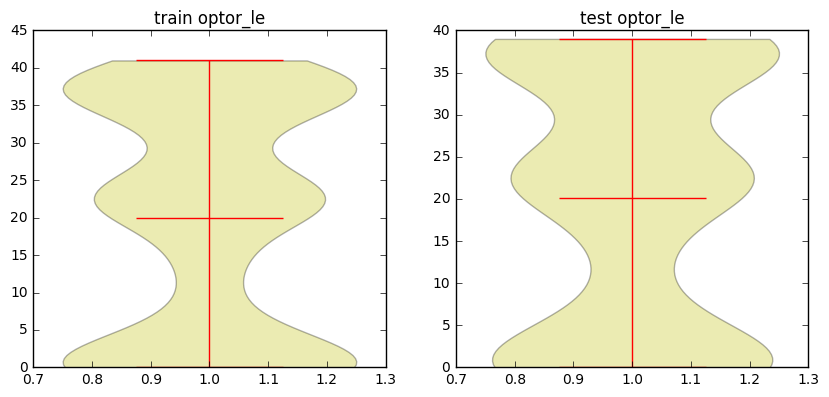

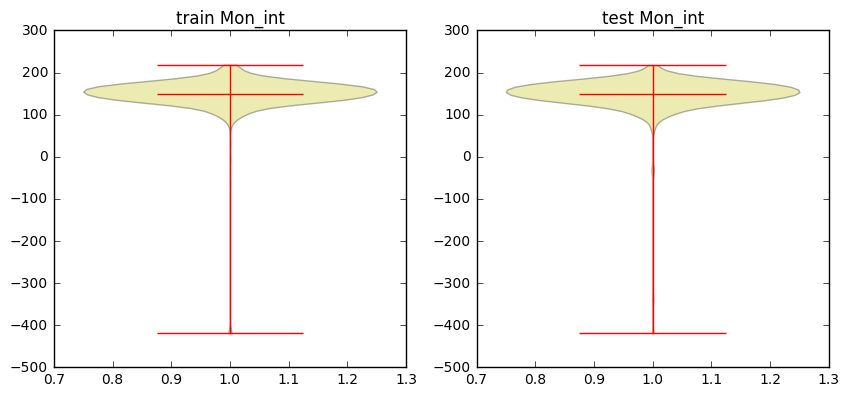

In [10]:
#Check whether train and test distribution are similar
con_v=['Surface Latitude','Surface Longitude','optor_le','Mon_int']
count=1
for i in range(len(con_v)):
    fig = plt.figure(figsize=(10,20))
    plt.subplot(len(con_v),2,count)
    plt.violinplot(X_train[con_v[i]],showmeans=True)
    plt.title("train "+con_v[i])
    
    plt.subplot(len(con_v),2,count+1)
    plt.violinplot(test_data[con_v[i]],showmeans=True)
    plt.title("test "+con_v[i])
    count+=2

In [11]:
# Voting for best classifier
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    #"Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=1000),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    #"Neural Net": MLPClassifier(alpha = 1),
    #"Naive Bayes": GaussianNB(),
}


def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
   
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models
 
 
def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    print(df_.sort_values(by=sort_by, ascending=False))
   
dict_models = batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 7)
display_dict_models(dict_models)

trained Random Forest in 4.71 s
trained Linear SVM in 0.77 s
trained Nearest Neighbors in 0.00 s
trained Logistic Regression in 0.07 s
trained Decision Tree in 0.01 s
            classifier  train_score  test_score  train_time
1        Random Forest     1.000000    0.897297    4.708617
4        Decision Tree     1.000000    0.863063    0.006551
2  Logistic Regression     0.786856    0.818018    0.069931
0           Linear SVM     0.851687    0.735135    0.765953
3    Nearest Neighbors     0.794849    0.697297    0.002746


In [12]:
#Predict Formation Producing Name using Random Forest
rf=RandomForestClassifier()
rf=rf.fit(data_x,data_y_le)
pred_y = rf.predict(pred_x)
result=pd.Series(le_f.inverse_transform(pred_y))
result.index = df[F_filter].index
df['Formation Producing Name']=df['Formation Producing Name'][~F_filter].append([result])
df['Formation_le']=le_f.fit_transform(df['Formation Producing Name'])

In [13]:
# Predict MD
MD_filter = df['Depth Total Driller']==0
data_full =df[~MD_filter]
data_x = data_full[['Surface Latitude','Surface Longitude','optor_le','Mon_int','Formation_le']]
data_y = data_full['Depth Total Driller']
pred = df[MD_filter]
pred_x = pred[['Surface Latitude','Surface Longitude','optor_le','Mon_int','Formation_le']]

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size=0.33, random_state=42)
rf.fit(X_train, Y_train)
rf.score(X_test,Y_test)
result_1=rf.predict(X_test)
result = pd.Series(rf.predict(pred_x))
result.index = df[MD_filter].index
df['Depth Total Driller']=df['Depth Total Driller'][~MD_filter].append([result])

In [14]:
# Score for MD prediction
print("MD prediction accuracy")
rf.score(X_test,Y_test)

MD prediction accuracy


0.84920164997864211

In [15]:
# Predict for TVD
tvd_filter = df['Depth True Vertical']==0
data_full =df[~tvd_filter]
data_x = data_full[['Surface Latitude','Surface Longitude','optor_le','Mon_int','Formation_le','Depth Total Driller']]
data_y = data_full['Depth True Vertical']
pred = df[tvd_filter]
pred_x = pred[['Surface Latitude','Surface Longitude','optor_le','Mon_int','Formation_le','Depth Total Driller']]

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size=0.33, random_state=42)
rf.fit(X_train, Y_train)
result = pd.Series(rf.predict(pred_x))
result.index = df[tvd_filter].index
df['Depth True Vertical']=df['Depth True Vertical'][~tvd_filter].append([result])

df['MD-TVD']=df['Depth Total Driller']-df['Depth True Vertical']
print("TVD prediction accuracy")
rf.score(X_test,Y_test)

TVD prediction accuracy


0.97927931213414632

In [16]:
# Prediction for Lateral length
LL_filter = df['Lat Len Gross Perf Intvl']==0
data_full =df[~LL_filter]
data_x = data_full[['Surface Latitude','Surface Longitude','optor_le',\
'Mon_int','Formation_le','Depth Total Driller','Depth True Vertical','MD-TVD']]
data_y = data_full['Lat Len Gross Perf Intvl']
pred = df[LL_filter]
pred_x = pred[['Surface Latitude','Surface Longitude','optor_le',\
'Mon_int','Formation_le','Depth Total Driller','Depth True Vertical','MD-TVD']]

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size=0.33, random_state=42)
rf.fit(X_train, Y_train)
result = pd.Series(rf.predict(pred_x))
result.index = df[LL_filter].index
df['Lat Len Gross Perf Intvl']=df['Lat Len Gross Perf Intvl'][~LL_filter].append([result])
print("Lateral length prediction accuracy")
rf.score(X_test,Y_test)

Lateral length prediction accuracy


0.7225961645482355